In [1]:
from prospect.models.templates import TemplateLibrary
from matplotlib.pyplot import *

In [2]:
# TemplateLibrary.describe('parametric_sfh')

In [3]:
# Since we're working with dwarf galaxies, we're gonna adjust these priors (ranges) below while building the model
model_params = TemplateLibrary['parametric_sfh']
print(model_params['mass']['prior']) # This prior has minimum mass 1e8 and maximum 1e12
print(model_params['tau']['prior'])
print(model_params['dust2']['prior'])

<class 'prospect.models.priors.LogUniform'>(mini=100000000.0,maxi=1000000000000.0)
<class 'prospect.models.priors.LogUniform'>(mini=0.1,maxi=30)
<class 'prospect.models.priors.TopHat'>(mini=0.0,maxi=2.0)


In [14]:
def build_model(object_redshift=None, ldist=10.0, fixed_metallicity=None, add_duste=False, **extras):
    from prospect.models.sedmodel import SedModel
    from prospect.models.templates import TemplateLibrary
    from prospect.models import priors
    
    model_params = TemplateLibrary['parametric_sfh']
    
    # If necessary, this is the step where you would need to change the initial values for the parameters
    model_params['lumdist'] = {'N':1, 'isfree':False, 'init':ldist, 'units':'Mpc'}
    model_params['zred']['init'] = 0.0
    model_params['dust2']['init'] = 0.05
    model_params['logzsol']['init'] = -0.5
    model_params['tage']['init'] = 13.
    model_params['mass']['init'] = 1e8
    
    # Changing the priors for some of the free parameters
    model_params['mass']['prior'] = priors.TopHat(mini=0.0, maxi=2.0)
    model_params['tau']['prior'] = priors.LogUniform(mini=1e-1, maxi=1e2)
    model_params['mass']['prior'] = priors.LogUniform(mini=1e6, maxi=1e10)
    
    # Providing minimum scale for the cloud of walkers for emcee
    model_params['mass']['disp_floor'] = 1e6
    model_params['tau']['disp_floor'] = 1.0
    model_params['tage']['disp_floor'] = 1.0
    
    # If optional (**extras) parameters are provided...
    if fixed_metallicity is not None:
        model_params['logzsol']['isfree'] = False
        # make it a fixed parameter
        model_params['logzsol']['init'] = fixed_metallicity
        
    if object_redshift is not None:
        model_params['zred']['isfree'] = False
        # make it a fixed parameter
        model_params['zred']['init'] = object_redshift
    
    if add_duste:
        model_params.update(TemplateLibrary['dust_emission'])
        
    model = SedModel(model_params)
    
    return model, model_params

In [5]:
run_params = {}
run_params['snr'] = 10.0
run_params['ldist'] = 10.0
run_params['object_redshift'] = 0.0
run_params['fixed_metallicity'] = None
run_params['add_duste'] = True

In [15]:
model = build_model(**run_params)
model_params['mass']['prior']

<class 'prospect.models.priors.LogUniform'>(mini=100000000.0,maxi=1000000000000.0)

In [7]:
model.params

{'zred': array([0.]),
 'mass': array([1.e+08]),
 'logzsol': array([-0.5]),
 'dust2': array([0.05]),
 'sfh': array([4]),
 'tage': array([13.]),
 'imf_type': array([2]),
 'dust_type': array([0]),
 'tau': array([1]),
 'lumdist': array([10.]),
 'add_dust_emission': array([ True]),
 'duste_umin': array([1.]),
 'duste_qpah': array([4.]),
 'duste_gamma': array([0.001])}

In [8]:
def build_sps(zcontinuous=1, **extras):
    from prospect.sources import CSPSpecBasis
    sps = CSPSpecBasis(zcontinuous=zcontinuous)
    return sps

In [9]:
run_params['zcontinuous'] = 1

In [10]:
sps = build_sps(**run_params)

In [11]:
def getObs(snr=10, ldist=10.0, obj=[], **extras_):
    
    from prospect.utils.obsutils import fix_obs
    import sedpy
    import numpy as np
    
    # obs is a dictionary of observational data to use for the fit
    obs = {}
    
    galex = ['galex_'+a for a in ['FUV', 'NUV']]
    sdss = [f'sdss_{c}0' for c in ['u', 'g', 'r', 'i', 'z']]
    spitzer = ['spitzer_irac_ch'+b for b in ['1', '2', '3', '4']]
    filternames = galex + sdss + spitzer
    
    obs['filters'] = sedpy.observate.load_filters(filternames)
    
    M_AB = np.array(obj)

    dm = 25 + 5.0 * np.log10(ldist)
    mags = M_AB + dm
    
    obs['maggies'] = 10**(-0.4*mags)
    obs['maggies_unc'] = (1./snr) * obs['maggies']
    
    obs['phot_mask'] = np.array(['spitzer' not in f.name for f in obs['filters']])
    obs['phot_wave'] = np.array([f.wave_effective for f in obs['filters']])

    obs['wavelength'] = None
    obs['spectrum'] = None
    obs['unc'] = None
    obs['mask'] = None
    
    obs = fix_obs(obs)
    
    return obs

run_params = {}
run_params['obj'] = [-11.36,  -11.36, -11.65, -12.15, -12.38, -12.43, -12.66, -11.53, -11.21, -10.79, -10.82]
run_params['snr'] = 10.0
run_params['ldist'] = 10.0

obs = getObs(**run_params)

In [12]:
theta = model.theta.copy()
initial_spec, initial_phot, initial_mfrac = model.sed(theta, obs=obs, sps=sps)

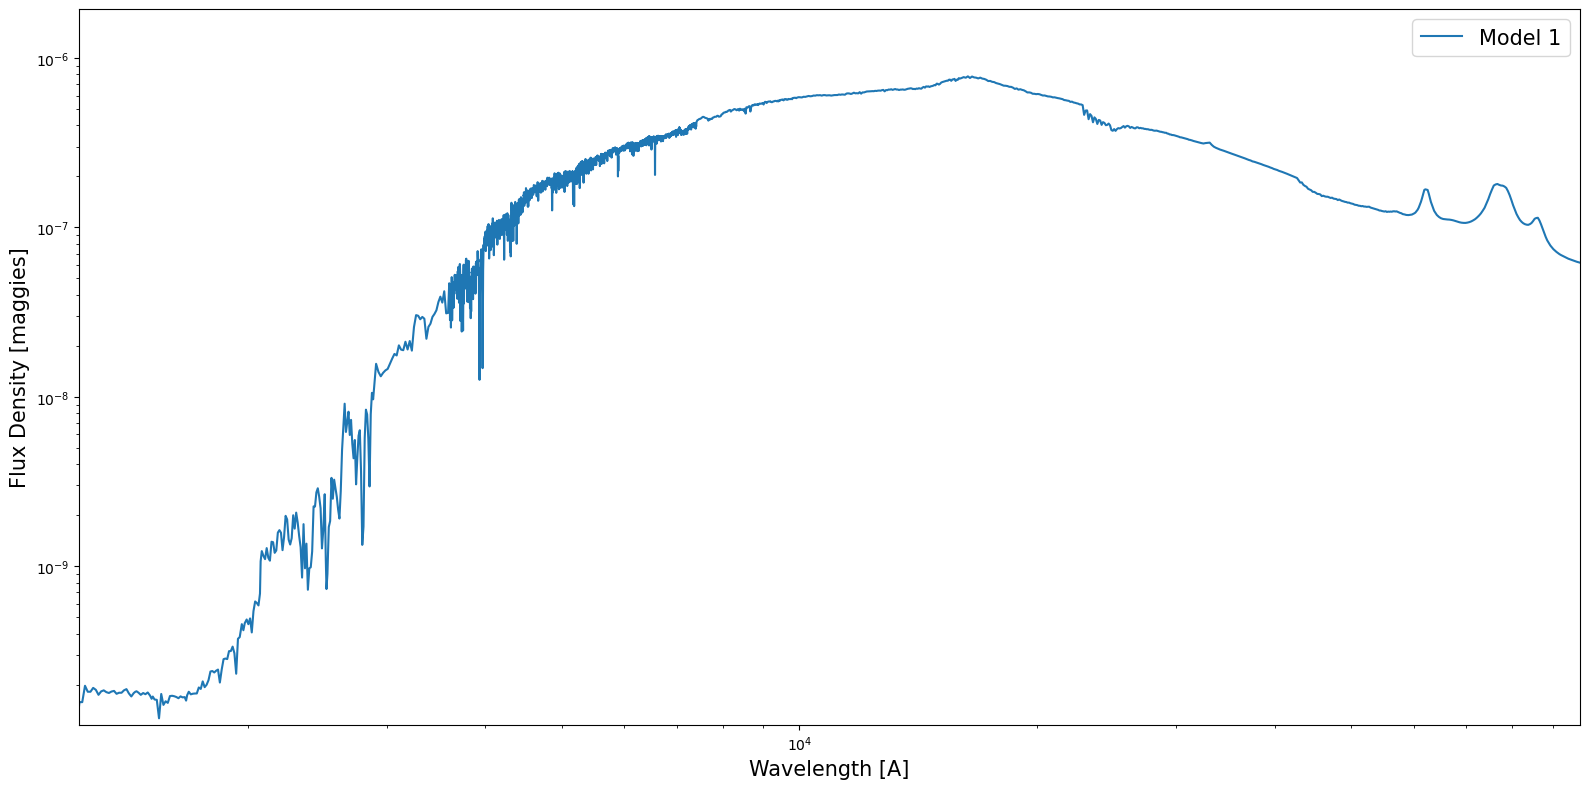

In [13]:
figure(figsize=(16,8))

a = 1.0 + model.params.get('zred', 0.0)

wphot = obs['phot_wave']

if obs['wavelength'] is None:
    wspec = sps.wavelengths
    wspec *= a
else:
    wspec = obs['wavelength']
    
xmin, xmax = np.min(wphot)*0.8, np.max(wphot)/0.8
temp = np.interp(np.linspace(xmin,xmax,10000), wspec, initial_spec)
ymin, ymax = temp.min()*0.8, temp.max()/0.4

loglog(wspec, initial_spec, label='Model 1')

xlabel('Wavelength [A]', fontsize=15)
ylabel('Flux Density [maggies]', fontsize=15)
xlim([xmin, xmax])
ylim([ymin, ymax])
xscale('log')
yscale('log')
legend(fontsize=15)

tight_layout()
show()
